## Setting the environment

In [41]:
# Importing essential libraries and functions
import pandas as pd
import numpy as np
import nltk
import re
import string
nltk.download("stopwords")
nltk.download("punkt_tab")
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#Visualisation Library
import matplotlib.pyplot as plt
import seaborn as sns
! pip install wordcloud
from wordcloud import WordCloud
# Feature Transformation Library
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
#Classification Report and model evaluation
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import accuracy_score


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Loading dataset

In [42]:
angry=pd.read_csv("/content/drive/MyDrive/Python/angriness.csv")
happy=pd.read_csv("/content/drive/MyDrive/Python/happiness.csv")
sad=pd.read_csv("/content/drive/MyDrive/Python/sadness.csv")

In [43]:
feelings=pd.concat([angry, happy, sad], axis=0)
feelings

content  intensity
0    Sometimes I’m not angry, I’m hurt and there’s ...  angriness
1                       Not available for busy people☺  angriness
2    I do not exist to impress the world. I exist t...  angriness
3    Everything is getting expensive except some pe...  angriness
4         My phone screen is brighter than my future 🙁  angriness
..                                                 ...        ...
630  Stop crying over yesterday and start smiling f...    sadness
631  An Eye with Dust ‘n A Heart with Trust Always ...    sadness
632  Tears come from the heart and not from the brain.    sadness
633  Sometimes you have to hold your head up high, ...    sadness
634  Instead of wiping your tears, wipe away the pe...    sadness

[2039 rows x 2 columns]

In [44]:
label_mapping = {'happiness': 1, 'angriness': 0, 'sadness': 2}
feelings['intensity']=feelings['intensity'].map(label_mapping)

In [45]:
feelings.head(2000)

content  intensity
0    Sometimes I’m not angry, I’m hurt and there’s ...          0
1                       Not available for busy people☺          0
2    I do not exist to impress the world. I exist t...          0
3    Everything is getting expensive except some pe...          0
4         My phone screen is brighter than my future 🙁          0
..                                                 ...        ...
591  ['You Hurt Me But I Still Love You.', 'True Lo...          2
592  ['You Hurt Me But I Still Love You.', 'True Lo...          2
593  ['You Hurt Me But I Still Love You.', 'True Lo...          2
594  ['You Hurt Me But I Still Love You.', 'True Lo...          2
595  ['You Hurt Me But I Still Love You.', 'True Lo...          2

[2000 rows x 2 columns]

In [46]:

feelings.sample(10)

content  intensity
444  Sometimes I hate getting close to people becau...          2
108  I’m sorry I was not good enough. But i tried t...          2
465  I wouldn’t have to manage my anger if people c...          0
435  Anger at lies lasts forever. Anger at truth ca...          0
513  There comes a point in your life when you real...          0
563  Definition of EX: Thanks for the experience. O...          0
631  I really want a relationship. A long one. A ha...          1
381       Victory is sweetest when you’ve known defeat          1
339            Our time has expired. Now exit my life.          0
289  I Never Insult People I Only Tell Them What Th...          0

In [47]:
feelings['content'][1]

1                       Not available for busy people☺
1    Love is a long sweet dream & marriage is an al...
1    Don’t expect me to tell you what you did wrong...
Name: content, dtype: object

In [48]:
feelings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2039 entries, 0 to 634
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    2039 non-null   object
 1   intensity  2039 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 112.3+ KB


## Data Preprocessing

In [49]:
feelings.isna().sum()

content      0
intensity    0
dtype: int64

In [50]:
feelings.shape

(2039, 2)

In [51]:
feelings['intensity'].value_counts()

intensity
1    708
0    696
2    635
Name: count, dtype: int64

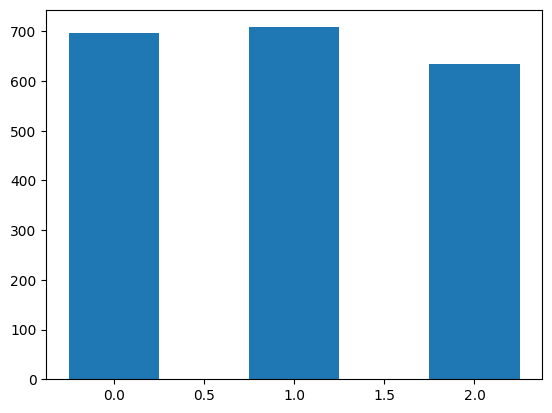

In [52]:
# Let's observe distribution of data
label_dis=feelings['intensity'].value_counts().to_dict()
ax=plt.bar(label_dis.keys(), label_dis.values(), width=0.5)

The Data is balanced as all the categories have similar amount of values

In [53]:
#Duplicates in dataset
len(feelings['content'])==len(feelings['content'].drop_duplicates())

False

In [54]:
len(feelings['content'])

2039

In [55]:
#checking the length of content column
feelings['length_of_ content']= feelings['content'].apply(lambda x: len(x.split(" ")))

feelings

content  intensity  \
0    Sometimes I’m not angry, I’m hurt and there’s ...          0   
1                       Not available for busy people☺          0   
2    I do not exist to impress the world. I exist t...          0   
3    Everything is getting expensive except some pe...          0   
4         My phone screen is brighter than my future 🙁          0   
..                                                 ...        ...   
630  Stop crying over yesterday and start smiling f...          2   
631  An Eye with Dust ‘n A Heart with Trust Always ...          2   
632  Tears come from the heart and not from the brain.          2   
633  Sometimes you have to hold your head up high, ...          2   
634  Instead of wiping your tears, wipe away the pe...          2   

     length_of_ content  
0                    11  
1                     5  
2                    22  
3                    11  
4                     9  
..                  ...  
630                   9  
631                  11  
632                  10  
633                  16  
634                  12  

[2039 rows x 3 columns]

<Axes: xlabel='intensity'>

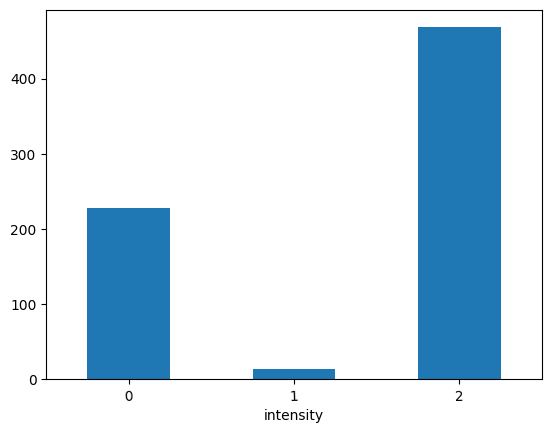

In [56]:
feelings.groupby(['intensity'])['length_of_ content'].mean().plot(kind="bar",rot=2)

Average Length of The Three Categories

In [57]:
feelings['char_count']=feelings['content'].apply(len)
feelings['word_count']=feelings['content'].apply(lambda x:len(x.split()))
feelings['word_density']=feelings['char_count']/(feelings['word_count']+1)
feelings['Punctuation_count']=feelings['content'].apply(lambda x:len("".join(_ for _ in x if _ in string.punctuation)))
feelings['upper_case_word_count']=feelings['content'].apply(lambda x:len([wrd for wrd in x.split() if wrd.isupper()]))
feelings['title_word_count']=feelings['content'].apply(lambda x:len([wrd for wrd in x.split() if wrd.istitle()]))

In [58]:
feelings.head(5)

content  intensity  \
0  Sometimes I’m not angry, I’m hurt and there’s ...          0   
1                     Not available for busy people☺          0   
2  I do not exist to impress the world. I exist t...          0   
3  Everything is getting expensive except some pe...          0   
4       My phone screen is brighter than my future 🙁          0   

   length_of_ content  char_count  word_count  word_density  \
0                  11          63          11      5.250000   
1                   5          30           5      5.000000   
2                  22          94          22      4.086957   
3                  11          77          11      6.416667   
4                   9          44           9      4.400000   

   Punctuation_count  upper_case_word_count  title_word_count  
0                  2                      0                 1  
1                  0                      0                 1  
2                  2                      2                 2  
3                  2                      0                 1  
4                  0                      0                 1

In [59]:
print("Subset on intensity for label 0",round(feelings[feelings['intensity']==0]['length_of_ content'].mean()))
print("Subset on intensity for label 1",round(feelings[feelings['intensity']==1]['length_of_ content'].mean()))
print("Subset on intensity for label 2",round(feelings[feelings['intensity']==2]['length_of_ content'].mean()))

Subset on intensity for label 0 228
Subset on intensity for label 1 13
Subset on intensity for label 2 468


Removing the Stopwords

In [60]:
def remove_stopwords(sentence):
    # Tokenize the sentence into words
    words = word_tokenize(sentence)

    # Remove stopwords

    filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]

    # Join the filtered words back into a sentence
    filtered_content = ' '.join(filtered_words)

    return filtered_content

In [61]:
# Calling remove_stopwords function
feelings['new1']=feelings['content'].apply(remove_stopwords)


In [62]:
feelings.head()

content  intensity  \
0  Sometimes I’m not angry, I’m hurt and there’s ...          0   
1                     Not available for busy people☺          0   
2  I do not exist to impress the world. I exist t...          0   
3  Everything is getting expensive except some pe...          0   
4       My phone screen is brighter than my future 🙁          0   

   length_of_ content  char_count  word_count  word_density  \
0                  11          63          11      5.250000   
1                   5          30           5      5.000000   
2                  22          94          22      4.086957   
3                  11          77          11      6.416667   
4                   9          44           9      4.400000   

   Punctuation_count  upper_case_word_count  title_word_count  \
0                  2                      0                 1   
1                  0                      0                 1   
2                  2                      2                 2   
3                  2                      0                 1   
4                  0                      0                 1   

                                                new1  
0      Sometimes ’ angry , ’ hurt ’ big difference .  
1                             available busy people☺  
2  exist impress world . exist live life way make...  
3  Everything getting expensive except people , g...  
4                     phone screen brighter future 🙁

Cleaning The Data

In [63]:
# Creating a function to clean the data
stopwords=nltk.corpus.stopwords.words('english')
wordnet_lemmatizer=WordNetLemmatizer()
def cleanData(row):
    row = row.lower()
    row = re.sub('[^a-zA-Z]',' ',row)
    token = row.split()
    removeStop = [i for i in token if i not in stopwords]
    lemm_text_temp = [wordnet_lemmatizer.lemmatize(word,pos='v') for word in removeStop]
    lemm_text = [wordnet_lemmatizer.lemmatize(word,pos='n') for word in lemm_text_temp]
    cleaned_string = ""
    for word in lemm_text:
        cleaned_string+=word
        cleaned_string+= ' '
    return cleaned_string

In [64]:
#calling text_clean function
feelings['clean_content']=feelings['new1'].apply(cleanData)

feelings.head()

content  intensity  \
0  Sometimes I’m not angry, I’m hurt and there’s ...          0   
1                     Not available for busy people☺          0   
2  I do not exist to impress the world. I exist t...          0   
3  Everything is getting expensive except some pe...          0   
4       My phone screen is brighter than my future 🙁          0   

   length_of_ content  char_count  word_count  word_density  \
0                  11          63          11      5.250000   
1                   5          30           5      5.000000   
2                  22          94          22      4.086957   
3                  11          77          11      6.416667   
4                   9          44           9      4.400000   

   Punctuation_count  upper_case_word_count  title_word_count  \
0                  2                      0                 1   
1                  0                      0                 1   
2                  2                      2                 2   
3                  2                      0                 1   
4                  0                      0                 1   

                                                new1  \
0      Sometimes ’ angry , ’ hurt ’ big difference .   
1                             available busy people☺   
2  exist impress world . exist live life way make...   
3  Everything getting expensive except people , g...   
4                     phone screen brighter future 🙁   

                                       clean_content  
0               sometimes angry hurt big difference   
1                             available busy people   
2  exist impress world exist live life way make h...  
3  everything get expensive except people get che...  
4                      phone screen brighter future

In [65]:
feelings['new_length']= feelings['clean_content'].apply(lambda x: len(x.split(" ")))

In [66]:
print("Subset on intensity for label 0",round(feelings[feelings['intensity']==0]['new_length'].mean()))
print("Subset on intensity for label 1",round(feelings[feelings['intensity']==1]['new_length'].mean()))
print("Subset on intensity for label 2",round(feelings[feelings['intensity']==2]['new_length'].mean()))

Subset on intensity for label 0 115
Subset on intensity for label 1 8
Subset on intensity for label 2 220


In [67]:
feelings['new_char_count']=feelings['clean_content'].apply(len)
feelings['new_word_count']=feelings['clean_content'].apply(lambda x:len(x.split()))
feelings['new_word_density']=feelings['new_char_count']/(feelings['new_word_count']+1)
feelings['new_Punctuation_count']=feelings['clean_content'].apply(lambda x:len("".join(_ for _ in x if _ in string.punctuation)))
feelings['new_upper_case_word_count']=feelings['clean_content'].apply(lambda x:len([wrd for wrd in x.split() if wrd.isupper()]))
feelings['new_title_word_count']=feelings['clean_content'].apply(lambda x:len([wrd for wrd in x.split() if wrd.istitle()]))

<Axes: xlabel='intensity'>

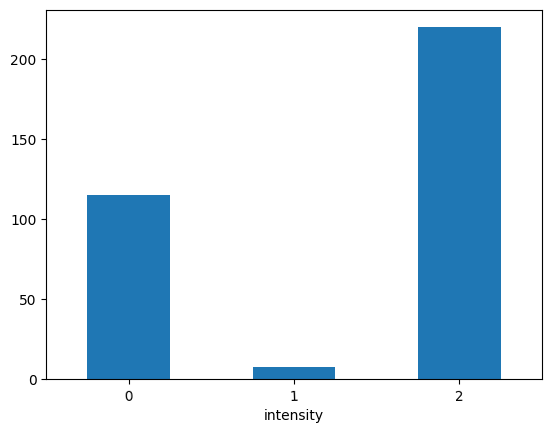

In [68]:
feelings.groupby(['intensity'])['new_length'].mean().plot(kind="bar",rot=2)

Average Lengths of the three categories is reduced after cleaning The Data.

In [92]:
feelings.sample(10)

content  intensity  \
221  Without Her Permission I Will Touch Her Only T...          1   
619  People always miss you more when they find out...          0   
648  It's nice when someone cares about you as much...          1   
150  I hate the fact that things between us never g...          2   
321  In this specific angry status article, I have ...          0   
106  If you like me Then raise your hand, If not th...          0   
682  A moment of patience in a moment of anger save...          0   
156  Anger makes you smaller, while forgiviness for...          0   
328  The past is gone; the future is not yet here, ...          1   
538  No matter how long you know someone, they even...          0   

     length_of_ content  char_count  word_count  word_density  \
221                  12          65          12      5.000000   
619                  16          85          16      5.000000   
648                  14          70          14      4.666667   
150                  11          56          11      4.666667   
321                  95         573          95      5.968750   
106                  14          69          14      4.600000   
682                  15          77          15      4.812500   
156                  14          84          14      5.600000   
328                  17          80          17      4.444444   
538                  13          76          13      5.428571   

     Punctuation_count  upper_case_word_count  title_word_count  \
221                  3                      1                12   
619                  1                      0                 1   
648                  2                      0                 0   
150                  1                      1                 1   
321                 13                      1                27   
106                  2                      0                 3   
682                  1                      1                 1   
156                  3                      0                 1   
328                  3                      0                 1   
538                  2                      0                 1   

                                                  new1  \
221           Without Permission Touch Wipe Tears .. !   
619     People always miss find much happier without .   
648                  's nice someone cares much care .   
150             hate fact things us never got better .   
321  specific angry status article , included lates...   
106                 like raise hand , raise standard .   
682  moment patience moment anger saves thousand mo...   
156  Anger makes smaller , forgiviness forces grow ...   
328    past gone ; future yet , need embrace present .   
538  matter long know someone , eventually show tru...   

                                         clean_content  new_length  \
221                without permission touch wipe tear            6   
619      people always miss find much happier without            8   
648                       nice someone care much care            6   
150                hate fact thing u never get better            8   
321  specific angry status article include latest a...          54   
106                    like raise hand raise standard            6   
682  moment patience moment anger save thousand mom...           9   
156  anger make smaller forgiviness force grow beyond            8   
328           past go future yet need embrace present            8   
538  matter long know someone eventually show true ...           9   

     new_char_count  new_word_count  new_word_density  new_Punctuation_count  \
221              35               5          5.833333                      0   
619              45               7          5.625000                      0   
648              28               5          4.666667                      0   
150              35               7          4.375000                      0   
321             382    

## Dividing dataset into training and test set

In [70]:
X_train, X_test, y_train, y_test= train_test_split(feelings['clean_content'], feelings['intensity'], test_size=0.2,random_state=42)#, stratify= feelings['intensity'])

In [71]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (1631,)
Shape of X_test: (408,)


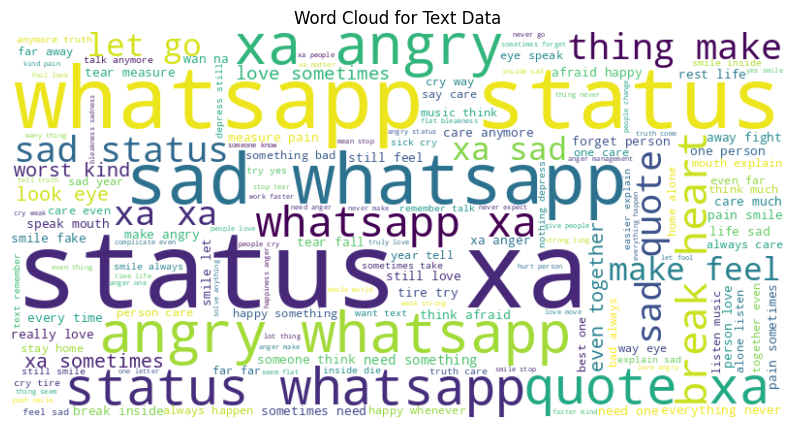

In [72]:
text_data_combined = ' '.join(X_train)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, max_words=150, background_color='white').generate(text_data_combined)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Text Data')
plt.show()

## Model fitting

In [73]:
#using Count vectorizer

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

modelclasses = [
    ["Logistic_Regression", LogisticRegression],
    ["NaiveBayes", MultinomialNB],
    ["RandomForest", RandomForestClassifier],
    ["GradientBoosting", GradientBoostingClassifier],
    ["Decision Tree Classifier", DecisionTreeClassifier]
]

results = []

for modelname, Model in modelclasses:
    model = Model()
    model.fit(X_train_vec, y_train)  # Ensure that y_train is an array of integers
    y_score = model.predict_proba(X_test_vec)
    y_pred = model.predict(X_test_vec)
    scores = cross_val_score(model, X_train_vec, y_train, cv=3,scoring='accuracy')
    training_score=np.round(model.score(X_train_vec, y_train),2)
    Accuracy= np.round(accuracy_score(y_test,y_pred), 2)
    auc = np.round(roc_auc_score(y_test, y_score, multi_class='ovr'), 2)
    results.append({'modelname': modelname, 'Accuracy_score': Accuracy, 'auc': auc})

results_df = pd.DataFrame(results)


In [74]:
results_df

modelname  Accuracy_score   auc
0       Logistic_Regression            0.78  0.92
1                NaiveBayes            0.62  0.80
2              RandomForest            0.81  0.93
3          GradientBoosting            0.73  0.90
4  Decision Tree Classifier            0.77  0.83

In [97]:
#using TFIDF vectorizer

vectorizer = TfidfVectorizer()
X_train_tf = vectorizer.fit_transform(X_train)
X_test_tf = vectorizer.transform(X_test)

modelclasses = [
    ["Logistic_Regression", LogisticRegression],
    ["NaiveBayes", MultinomialNB],
    ["RandomForest", RandomForestClassifier],
    ["GradientBoosting", GradientBoostingClassifier],
    ["Decision Tree Classifier", DecisionTreeClassifier]
]

results = []

for modelname, Model in modelclasses:
    model = Model()
    model.fit(X_train_tf, y_train)  # Ensure that y_train is an array of integers
    y_score2 = model.predict_proba(X_test_tf)
    y_pred2 = model.predict(X_test_tf)
    scores2 = cross_val_score(model, X_train_tf, y_train, cv=3,scoring='accuracy')
    class_report = classification_report(y_test, y_pred2)
    auc2 = np.round(roc_auc_score(y_test, y_score2, multi_class='ovr'), 2)
    training_score2=np.round(model.score(X_train_tf, y_train),2)
    Accuracy2 = np.round(accuracy_score(y_test,y_pred2), 2)
    results.append({'modelname': modelname, 'auc_score': auc2, 'accuracy': Accuracy2})

results_df1 = pd.DataFrame(results)


In [98]:
results_df1

modelname  auc_score  accuracy
0       Logistic_Regression       0.93      0.79
1                NaiveBayes       0.89      0.70
2              RandomForest       0.93      0.80
3          GradientBoosting       0.92      0.76
4  Decision Tree Classifier       0.81      0.75

## Model performance

In [77]:
print(class_report)

              precision    recall  f1-score   support

           0       0.78      0.74      0.76       152
           1       0.74      0.72      0.73       137
           2       0.68      0.75      0.71       119

    accuracy                           0.74       408
   macro avg       0.74      0.74      0.74       408
weighted avg       0.74      0.74      0.74       408



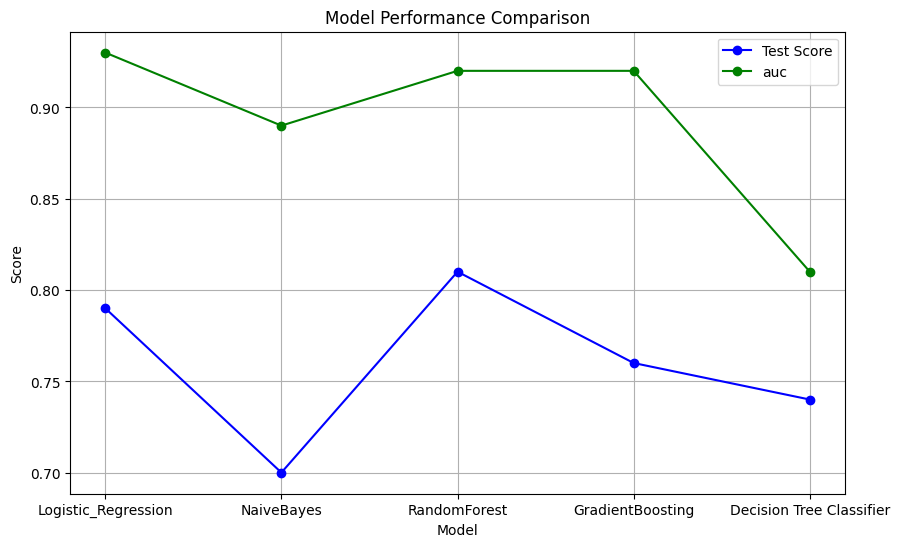

In [78]:
# Model Performance Charts(TFIDFvectorizer)
model_names = results_df1['modelname']
test_scores = results_df1['accuracy']
auc = results_df1['auc_score']

plt.figure(figsize=(10, 6))

# Line chart for test scores
plt.plot(model_names, test_scores, marker='o', label='Test Score', linestyle='-', color='blue')

# Line chart for accuracy scores
plt.plot(model_names, auc, marker='o', label='auc', linestyle='-', color='green')

plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

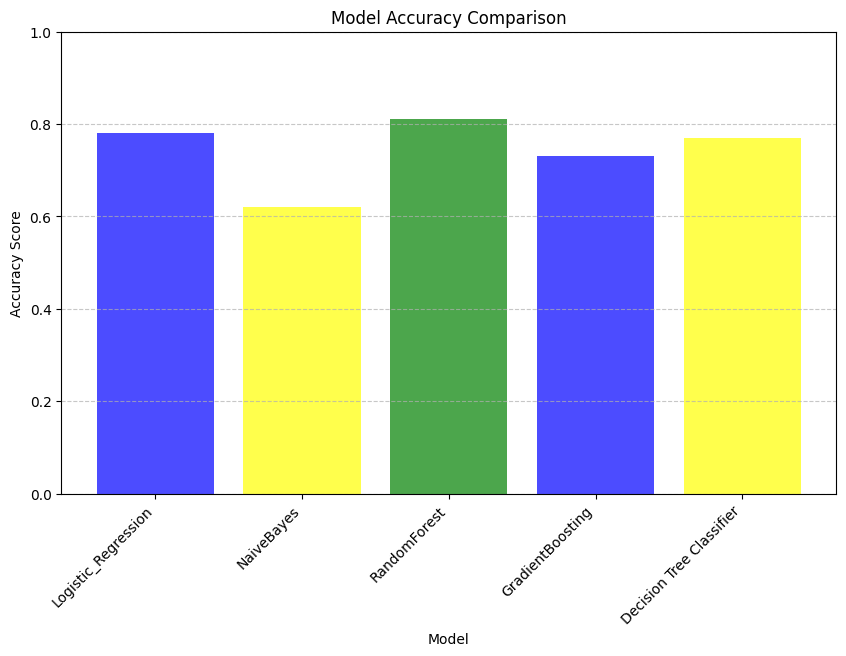

In [79]:
# Model Performance Charts(Countvectorizer)

model_names = results_df['modelname']
accuracy_scores = results_df['Accuracy_score']
auc = results_df['auc']

# Plotting a bar chart for accuracy scores
plt.figure(figsize=(10, 6))

plt.bar(model_names, accuracy_scores, color=['blue','yellow','green'], alpha=0.7)

plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1)  # Set the y-axis limit between 0 and 1 for accuracy score
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

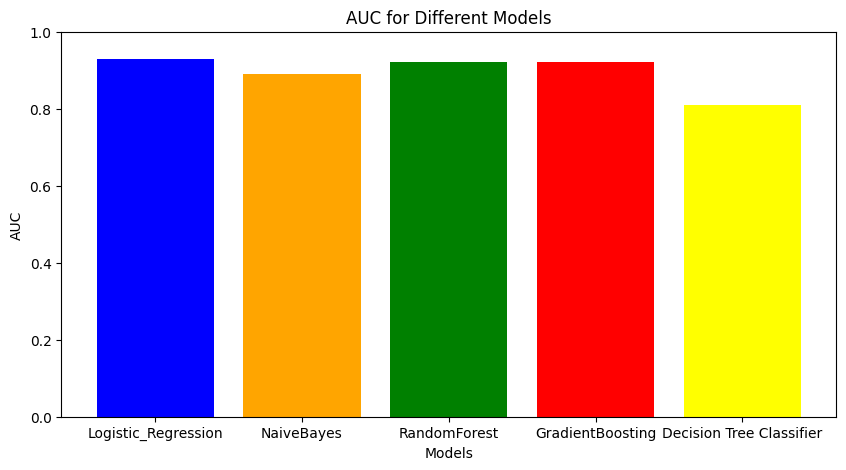

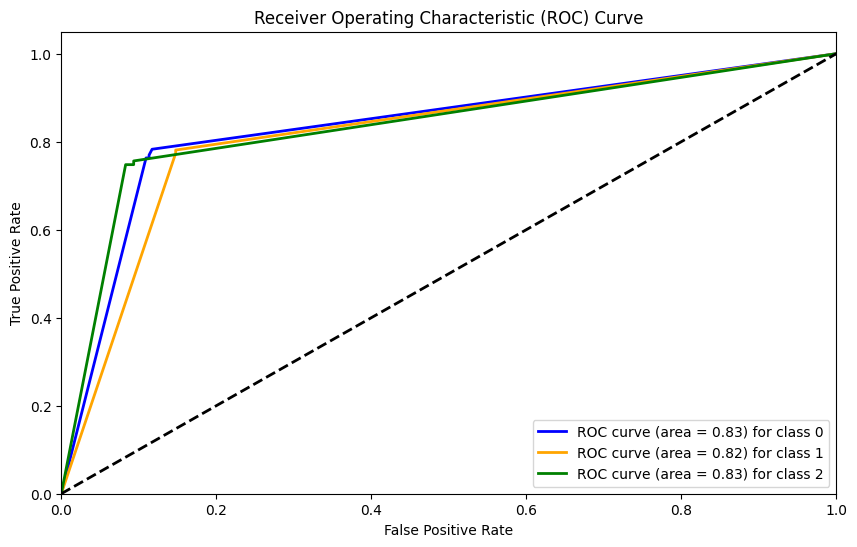

In [80]:
# for TFIDF vectorizer

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Bar plot for AUC
plt.figure(figsize=(10, 5))
plt.bar(results_df1['modelname'], results_df1['auc_score'], color=['blue', 'orange', 'green','red','yellow'])
plt.title('AUC for Different Models')
plt.xlabel('Models')
plt.ylabel('AUC')
plt.ylim(0, 1)
plt.show()

# ROC Curve
plt.figure(figsize=(10, 6))

# Binarize the output
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
colors = cycle(['blue', 'orange', 'green'])
for i, color in zip(range(len(np.unique(y_test))), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


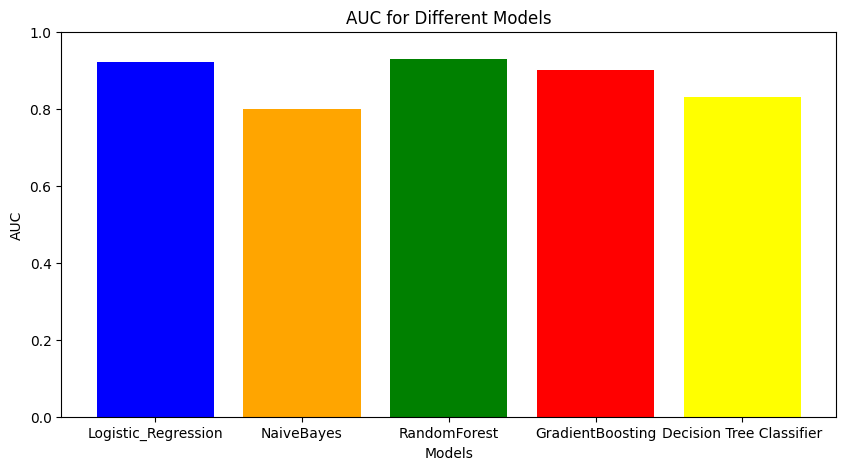

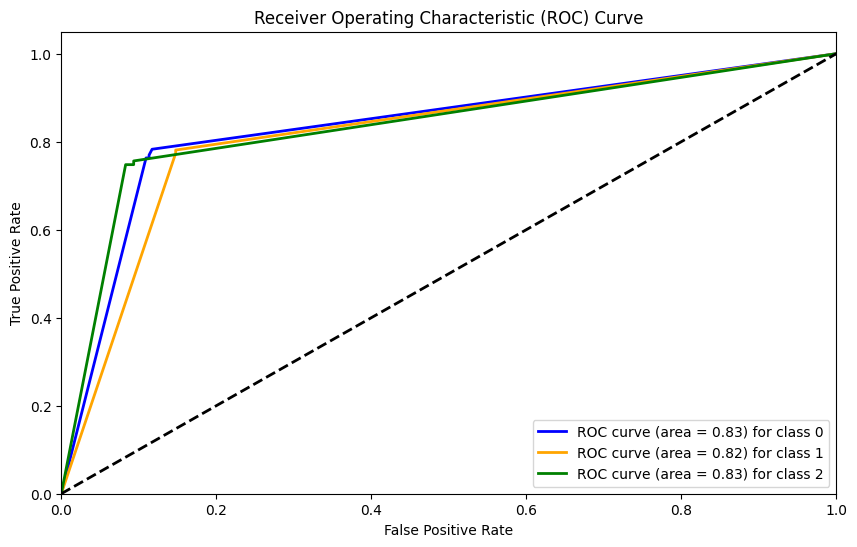

In [81]:
# for Countvectorizer

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Bar plot for AUC
plt.figure(figsize=(10, 5))
plt.bar(results_df['modelname'], results_df['auc'], color=['blue', 'orange', 'green','red','yellow'])
plt.title('AUC for Different Models')
plt.xlabel('Models')
plt.ylabel('AUC')
plt.ylim(0, 1)
plt.show()

# ROC Curve
plt.figure(figsize=(10, 6))

# Binarize the output
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
colors = cycle(['blue', 'orange', 'green'])
for i, color in zip(range(len(np.unique(y_test))), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [82]:
text_model=make_pipeline(TfidfVectorizer(),RandomForestClassifier())
text_model.fit(X_train,y_train)
y_pred=text_model.predict(X_test)
y_pred

array([0, 1, 2, 2, 1, 0, 0, 1, 0, 2, 0, 1, 0, 1, 0, 1, 1, 0, 2, 0, 0, 0,
       0, 2, 1, 1, 2, 1, 0, 2, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 2, 1, 1, 0, 1, 2, 2, 0, 0, 0, 2, 1, 2, 1, 0, 0,
       1, 1, 2, 1, 1, 0, 1, 0, 1, 1, 0, 2, 1, 0, 0, 0, 1, 1, 2, 2, 0, 1,
       2, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 0, 1, 1, 0, 1, 1, 2,
       1, 0, 1, 0, 2, 0, 1, 1, 0, 0, 1, 2, 2, 1, 0, 1, 0, 1, 1, 1, 2, 0,
       1, 1, 2, 0, 0, 0, 2, 2, 1, 1, 2, 2, 0, 2, 1, 1, 2, 1, 1, 2, 1, 2,
       2, 0, 1, 1, 2, 1, 2, 1, 2, 1, 0, 0, 0, 1, 1, 2, 0, 0, 1, 2, 1, 1,
       0, 0, 0, 1, 1, 1, 2, 2, 2, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 2, 1,
       0, 2, 0, 0, 1, 1, 2, 0, 0, 1, 2, 0, 1, 1, 0, 2, 2, 2, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 0, 1, 2, 1, 2, 0, 2, 1, 1, 0,
       1, 1, 0, 0, 2, 0, 1, 1, 2, 1, 0, 1, 0, 0, 0, 2, 2, 1, 2, 1, 1, 1,
       2, 2, 0, 2, 1, 0, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 2, 1, 2, 2, 0, 1, 2, 0, 2, 1, 0, 1, 2,

In [83]:
import pickle
pickle.dump(text_model,open('model.pkl','wb'))

In [84]:
!pip install streamlit --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.6 MB/s eta 0:00:00


In [96]:
%%writefile app.py
import streamlit as st
import pickle
import pandas as pd
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
stopwords=nltk.corpus.stopwords.words('english')
import numpy as np
import matplotlib.pyplot as plt
model=pickle.load(open('model.pkl','rb'))
def cleanData(row):
    row = row.lower()
    row = re.sub('[^a-zA-Z]',' ',row)
    token = row.split()
    removeStop = [i for i in token if i not in stopwords]
    cleaned_string = ""
    for word in removeStop:
        cleaned_string+=word
        cleaned_string+= ' '
    return cleaned_string

st.title("Intensity Detector")
ip=st.text_input("Enter message: ")
op=model.predict([cleanData(ip)])

if st.button("Detect"):
    if op==0:
        final='Angry'
    elif op==1:
        final='Happy'
    else :
        final="Sad"
    st.subheader("The Intensity of above sentence is "+str(final))

Overwriting app.py


In [94]:
!streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸⠼
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.245.213.63:8501

⠴⠦⠧⠇your url is: https://orange-jeans-search.loca.lt
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[

## Making Predictions

In [87]:
# Testing the model
def test_model_with_user_input(model,)

    # Get user input
    user_input = input("Enter a text for classification: ")

    # Vectorizing the user input using the  Countvectorizer
    user_input_vectorized = vectorizer.transform([user_input])

    # Make predictions using the trained model
    prediction = model.predict(user_input_vectorized)

    return prediction[0]

# Example usage:
predicted_class = test_model_with_user_input(model, vectorizer)

print(f"\nPredicted class: {predicted_class}")


SyntaxError: expected ':' (<ipython-input-87-7cf8ec61c7d1>, line 2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
feelings.head()